In [17]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs
import pandas as pd
import seaborn as sns
from utils import get_firing_field

device = 'cpu'

In [18]:
trained_dir = '/home/chingf/engram/Ching/'

In [19]:
def run(exp_dir):
    num_states = 20

    # Test dataset
    lr_probs = [[1,1,1], [4,1,1], [1,1,4]]
    lr_prob = lr_probs[np.random.choice(len(lr_probs))]
    dset = inputs.Sim1DWalk(num_steps=3000, num_states=num_states, left_right_stay_prob=lr_prob)
    dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)

    with open(exp_dir + 'net_configs.p', 'rb') as f:
        net_configs = pickle.load(f)
    net_configs['num_states'] = num_states

    # Load that model and test
    net = STDP_SR(**net_configs)
    net.load_state_dict(torch.load(exp_dir + 'model.pt'))
    net.set_num_states(num_states)
    with torch.no_grad():
        _, outputs = net(dg_inputs, reset=True)
    
    rnn_T = net.get_T().numpy()
    rnn_M = net.get_M()
    try:
        rnn_M = rnn_M.numpy()
    except:
        pass
    est_T = dset.est_T
    est_M = np.linalg.pinv(
        np.eye(est_T.shape[0]) - net.gamma*est_T
        )
    return np.mean(np.abs(rnn_T - est_T)), np.mean(np.abs(rnn_M - est_M))

# Plot Test Loss over $\gamma$s

In [20]:
# Or gather from tfevents manually
gridsearch_dir = f"{trained_dir}02_gamma_v_ss/"
gammas = []
T_maes = []
M_maes = []

for gamma in os.listdir(gridsearch_dir):
    gamma_dir = gridsearch_dir + f'{gamma}/'
    if not os.path.isdir(gamma_dir): continue
        
    best_iter = None; best_iter_val = np.inf
    for _iter in os.listdir(gamma_dir):
        iter_dir = gamma_dir + f'{_iter}/'
        if not os.path.isfile(iter_dir + 'net_configs.p'):
            continue
        for file in os.listdir(iter_dir):
            if 'tfevents' not in file: continue
            tfevents_file = iter_dir + file
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            iter_val = [event_acc.Scalars('loss_train')[-i].value for i in range(10)]
            iter_val = np.mean(iter_val)
            if iter_val < best_iter_val:
                best_iter_val = iter_val
                best_iter = _iter
            break
    for _ in range(10):
        T_mae, M_mae = run(gamma_dir + f'{best_iter}/')
        gammas.append(gamma)
        T_maes.append(T_mae)
        M_maes.append(M_mae)

gammas = np.array(gammas)
T_maes = np.array(T_maes)
M_maes = np.array(M_maes)
                
results = {
    'gammas': gammas,
    'T_maes': T_maes,
    'M_maes': M_maes
}

Text(0.5, 0, 'Baseline $\\gamma$')

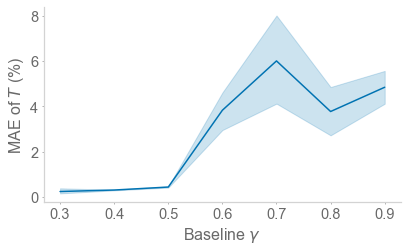

In [24]:
df = pd.DataFrame({
    'gammas': gammas,
    'T_maes': T_maes*100,
    'M_maes': M_maes
})
plt.figure(figsize=(6.4, 4.8*0.75))
sns.lineplot(x = 'gammas', y='T_maes', data=df)
plt.ylabel("MAE of $T$ (%)")
plt.xlabel("Baseline $\gamma$")

Text(0.5, 0, 'Baseline $\\gamma$')

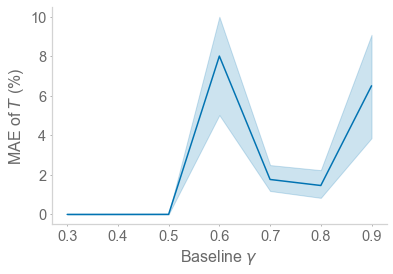

In [22]:
df = pd.DataFrame({
    'gammas': gammas,
    'T_maes': T_maes*100,
    'M_maes': np.clip(M_maes, 0, 10)
})
plt.figure()
sns.lineplot(x = 'gammas', y='M_maes', data=df)
plt.ylabel("MAE of $T$ (%)")
plt.xlabel("Baseline $\gamma$")

# Plot Training Loss over $\gamma$s

In [16]:
experiment_dir = f"{trained_dir}02_gamma_v_ss/"
iterations = []
losses = []
exps = []

for gamma in os.listdir(experiment_dir):
    gamma_exp_dir = experiment_dir + f'{gamma}/'
    for gamma_iter in os.listdir(gamma_exp_dir):
        for file in os.listdir(gamma_exp_dir + gamma_iter):
            if 'tfevents' not in file: continue
            tfevents_file = gamma_exp_dir + gamma_iter + '/' + file
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            scalar_events = event_acc.Scalars('loss_train')
            for i in range(len(scalar_events)):
                iterations.append(scalar_events[i].step)
                losses.append(scalar_events[i].value)
                exps.append(gamma)
            break

iterations = np.array(iterations)
losses = np.array(losses)
exps = np.array(exps)

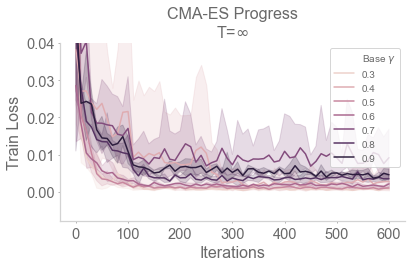

In [18]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame({'Iterations': iterations, 'Loss': losses, 'Gamma': exps})
fig, ax = plt.subplots()
sns.lineplot(x='Iterations', y='Loss', hue='Gamma', legend='full', data=df, ax=ax)
plt.xlabel('Iterations')
plt.ylabel('Train Loss')
plt.title('CMA-ES Progress\nT=$\infty$')
plt.ylim(top=0.04)
legend = ax.legend(prop={'size': 10})
legend.texts[0].set_text("Base $\gamma$")
plt.tight_layout()
plt.savefig('gamma_v_ss.png', dpi=200)
plt.show()

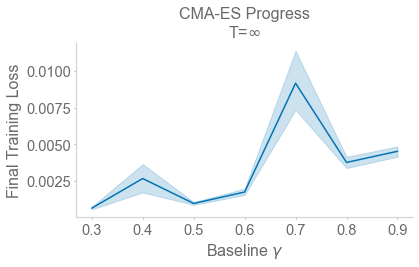

In [22]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame(
    {'Loss': losses[iterations>500], 'Gamma': exps[iterations>500]})
fig, ax = plt.subplots()
sns.lineplot(x='Gamma', y='Loss', data=df, ax=ax)
plt.xlabel('Baseline $\gamma$')
plt.ylabel('Final Training Loss')
plt.title('CMA-ES Progress\nT=$\infty$')
plt.tight_layout()
#plt.savefig('gamma_v_ss.png', dpi=200)
plt.show()